<a href="https://colab.research.google.com/github/TheDataDesk/EV-Mobility-Modelling/blob/main/AnalysisColab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling the S-Curve of EV Adoption & integrating National Policies


### A Comparative Study of Norway, Germany, and the United States (2016–2030)



## Objective

The objective of this study is to evaluate and forecast electric vehicle (EV) adoption trajectories across **Norway**, **Germany**, and the **United States** by integrating national policy. Specifically, the project aims to:

(1) fit logistic S-curves to historical EV share data to capture country-specific adoption patterns,

(2) overlay and analyze the temporal placement of key policy milestones from 2016 to 2030, and

(3) visually and quantitatively assess the potential catalytic impact of these policies on EV growth.

This research seeks to provide a data-driven framework for understanding how timing, type, and status of national policies align with shifts in EV market penetration, offering insights for future policy design and international benchmarking.

### Caveats

- U.S. diesel data is not directly reported and is assumed negligible due to low market share (<3%). Petrol and diesel are combined as PetrolOnly in U.S. data.

- Germany and Norway include diesel explicitly, offering more granularity for analysis.



## Data Loading

In [2]:
!git clone https://github.com/TheDataDesk/EV-Mobility-Modelling

Cloning into 'EV-Mobility-Modelling'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 65 (delta 27), reused 8 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (65/65), 6.19 MiB | 20.25 MiB/s, done.
Resolving deltas: 100% (27/27), done.


In [3]:
!pwd
%cd /content/EV-Mobility-Modelling
import pandas as pd
# Load Germany dataset
germany_df = pd.read_csv("data/Germany_Fahrzeugzulassungen.csv")

# Load Norway dataset
norway_df = pd.read_csv("data/Norway_Statensvegvesen.csv")

# Load US dataset (from your earlier structured table)
us_df = pd.read_csv("data/US_Afdcenergy.csv")

# Preview all
display(germany_df.head())
display(norway_df.head())
display(us_df.head())


/content
/content/EV-Mobility-Modelling


,Year,Benzin,Diesel,LPG (einschl. bivalent),CNG (einschl. bivalent),BEV,Hybrid (gesamt),Plug-in Hybrid,Sonstige,Insgesamt
0,2005,1903190,1425576,1380,8053,47,3589,NaN,287,3342122
1,2006,1910823,1535881,4220,11555,19,5278,NaN,185,3467961
2,2007,1622276,1501566,5419,11208,8,7591,NaN,95,3148163
3,2008,1695972,1361457,14175,11896,36,6464,NaN,40,3090040
4,2009,2608767,1168633,11083,10062,162,8374,NaN,94,3807175


,YYYYMM,Total: New,PetrolOnly: New,DieselOnly: New,BEV: New,Non-plugin hybrid: New,Plugin hybrid: New,Total: Used,PetrolOnly: Used,DieselOnly: Used,BEV: Used,Non-plugin hybrid: Used,Plugin hybrid: Used
0,199001,5733,5394,339,0,0,0,165,136.0,29.0,0,0.0,0.0
1,199002,5246,4990,255,0,0,0,150,118.0,32.0,0,0.0,0.0
2,199003,6007,5646,360,1,0,0,150,128.0,22.0,0,0.0,0.0
3,199004,5302,4963,339,0,0,0,124,96.0,28.0,0,0.0,0.0
4,199005,6466,6039,427,0,0,0,187,148.0,39.0,0,0.0,0.0


,Year,PetrolOnly: New,DieselOnly: New,BEV: New,Non-plugin hybrid: New,Plugin hybrid: New,Total: New
0,2016,224855100,0,280300,3487600,254000,224855100
1,2017,227415700,0,377100,3691400,344600,227415700
2,2018,229074100,0,572600,3781100,461300,229074100
3,2019,231358800,0,783600,3976300,536600,231358800
4,2020,231992200,0,1018900,4219300,594400,231992200


## Data Cleaning & Preprocessing

#### Germany

In [ ]:
# Step 1: Check date range
print("Year range:", germany_df["Year"].min(), "to", germany_df["Year"].max())

Year range: 2005 to 2024


In [ ]:
#Step 2: Drop rows with missing critical values
germany_df = germany_df.dropna(subset=[
    "Benzin", "Diesel", "LPG (einschl. bivalent)",
    "CNG (einschl. bivalent)", "BEV"
])

In [ ]:
# Step 3: Create clean simplified structure (keep original column names for now)
germany_simple = pd.DataFrame()
germany_simple["Year"] = germany_df["Year"]
germany_simple["EV"] = germany_df["BEV"]
germany_simple["FossilFuel"] = (
    germany_df["Benzin"] +
    germany_df["Diesel"] +
    germany_df["LPG (einschl. bivalent)"] +
    germany_df["CNG (einschl. bivalent)"]
)
germany_simple["Total"] = germany_simple["EV"] + germany_simple["FossilFuel"]


In [ ]:
# Sanity check for missing values in the new DataFrame
print("\nMissing values per column:")
print(germany_simple.isna().sum())



Missing values per column:
Year          0
EV            0
FossilFuel    0
Total         0
dtype: int64


In [ ]:
# Preview the result
germany_simple.head()

,Year,EV,FossilFuel,Total
0,2005,47,3338199,3338246
1,2006,19,3462479,3462498
2,2007,8,3140469,3140477
3,2008,36,3083500,3083536
4,2009,162,3798545,3798707


#### Norway

In [ ]:
# Step 1: Extract Year from YYYYMM
norway_df = norway_df.copy()
norway_df["Year"] = norway_df["YYYYMM"] // 100

In [ ]:
# Step 2: Group by Year (sum across months)
norway_yearly = norway_df.groupby("Year").sum().reset_index()

In [ ]:
print("Year range:", norway_df["Year"].min(), "to", norway_df["Year"].max())

Year range: 1990 to 2025


In [ ]:
# Step 3: Create simplified structure
norway_simple = pd.DataFrame()
norway_simple["Year"] = norway_yearly["Year"]
norway_simple["EV"] = norway_yearly["BEV: New"]
norway_simple["FossilFuel"] = norway_yearly["PetrolOnly: New"] + norway_yearly["DieselOnly: New"]
norway_simple["Total"] = norway_simple["EV"] + norway_simple["FossilFuel"]


In [ ]:
# Step 4: Preview and sanity check
print("\nMissing values:")
print(norway_simple.isna().sum())


Missing values:
Year          0
EV            0
FossilFuel    0
Total         0
dtype: int64


In [ ]:
norway_simple.head()

,Year,EV,FossilFuel,Total
0,1990,2,66549,66551
1,1991,0,57775,57775
2,1992,42,66381,66423
3,1993,13,69167,69180
4,1994,20,93997,94017


#### United states of America (USA)

In [ ]:
# Step 1: Check date range
print("Year range:", us_df["Year"].min(), "to", us_df["Year"].max())

Year range: 2016 to 2023


In [ ]:
# Step 2: Create simplified structure
us_simple = pd.DataFrame()
us_simple["Year"] = us_df["Year"]
us_simple["EV"] = us_df["BEV: New"]
us_simple["FossilFuel"] = us_df["PetrolOnly: New"] + us_df["DieselOnly: New"]
us_simple["Total"] = us_simple["EV"] + us_simple["FossilFuel"]


In [ ]:
# Step 3: Preview and sanity check
print("\nMissing values:")
print(us_simple.isna().sum())


Missing values:
Year          0
EV            0
FossilFuel    0
Total         0
dtype: int64


In [ ]:
us_simple.head()

,Year,EV,FossilFuel,Total
0,2016,280300,224855100,225135400
1,2017,377100,227415700,227792800
2,2018,572600,229074100,229646700
3,2019,783600,231358800,232142400
4,2020,1018900,231992200,233011100


In [ ]:
norway_filtered = norway_simple[(norway_simple['Year'] >= 2016) & (norway_simple['Year'] <= 2023)]

In [ ]:
germany_filtered = germany_simple[(germany_simple['Year'] >= 2016) & (germany_simple['Year'] <= 2023)]

In [ ]:
us_filtered = us_simple[(us_simple['Year'] >= 2016) & (us_simple['Year'] <= 2023)]

In [ ]:
us_filtered['country'] = 'USA'
norway_filtered['country'] = 'Norway'
germany_filtered['country'] = 'Germany'

/tmp/ipython-input-26-4148838808.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  norway_filtered['country'] = 'Norway'
/tmp/ipython-input-26-4148838808.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  germany_filtered['country'] = 'Germany'


In [ ]:
df = pd.concat([us_filtered, norway_filtered, germany_filtered], ignore_index=True)

In [ ]:
df['EV_share'] = df['EV'] / df['Total']
df['FossilFuel_share'] = df['FossilFuel'] / df['Total']

In [ ]:
df.sample(n=10)


,Year,EV,FossilFuel,Total,country,EV_share,FossilFuel_share
23,2023,524219,1479715,2003934,Germany,0.261595,0.738405
16,2016,11410,3292134,3303544,Germany,0.003454,0.996546
20,2020,194163,2195321,2389484,Germany,0.081257,0.918743
12,2020,76684,23239,99923,Norway,0.767431,0.232569
4,2020,1018900,231992200,233011100,USA,0.004373,0.995627
19,2019,63281,3304503,3367784,Germany,0.018790,0.981210
8,2016,24012,94591,118603,Norway,0.202457,0.797543
2,2018,572600,229074100,229646700,USA,0.002493,0.997507
18,2018,36062,3269297,3305359,Germany,0.010910,0.989090
0,2016,280300,224855100,225135400,USA,0.001245,0.998755


In [ ]:
df_long = df.melt(id_vars=['Year', 'country'],
                  value_vars=['EV', 'FossilFuel'],
                  var_name='FuelType',
                  value_name='VehicleCount')

df_long.sample(n=10)


,Year,country,FuelType,VehicleCount
44,2020,Germany,FossilFuel,2195321
0,2016,USA,EV,280300
19,2019,Germany,EV,63281
3,2019,USA,EV,783600
41,2017,Germany,FossilFuel,3331387
13,2021,Norway,EV,113629
14,2022,Norway,EV,138172
33,2017,Norway,FossilFuel,78861
11,2019,Norway,EV,60142
24,2016,USA,FossilFuel,224855100


In [ ]:
# Sanity check
df.isnull().sum()
df.duplicated().sum()


np.int64(0)

In [ ]:
df['country'].value_counts()

,count
country,
USA,8
Norway,8
Germany,8


In [ ]:
df['Year'].value_counts().sort_index()
df.groupby('country')[['EV', 'FossilFuel']].describe()

EV                                                            \
        count         mean           std       min        25%       50%   
country                                                                   
Germany   8.0   210088.875  2.116612e+05   11410.0   33310.50  128722.0   
Norway    8.0    74497.750  4.106288e+04   24012.0   42682.25   68413.0   
USA       8.0  1310637.500  1.145376e+06  280300.0  523725.00  901250.0   

                               FossilFuel                             \
                75%        max      count         mean           std   
country                                                                
Germany   384610.50   524219.0        8.0    2466999.5  9.240750e+05   
Norway    106839.25   138172.0        8.0      41719.0  3.415087e+04   
USA      1701375.00  3555900.0        8.0  233704900.0  6.964123e+06   

                                                                            
                 min           25%          50%           75%          max  
country                                                                     
Germany    1352571.0  1.503230e+06    2732309.0  3.295226e+06    3331387.0  
Norway        5379.0  1.218275e+04      35098.0  6.648825e+04      94591.0  
USA      224855100.0  2.286595e+08  231675500.0  2.408678e+08  242870900.0

## Data Analysis

### EV Share Over Time by Country (Line Plot)

In [ ]:
import plotly.express as px

df['EV_share'] = df['EV'] / df['Total']

fig = px.line(df, x='Year', y='EV_share', color='country',
              markers=True,
              title='Graph 1: EV Share Over Time by Country',
              labels={'EV_share': 'EV Share (Fraction)'})
fig.show()

This chart captures the real-world trajectory of electric vehicle (EV) adoption in three countries: Norway, Germany, and the United States, over the years 2016 to 2023.

- Norway leads the pack by a wide margin. From around 30% EV share in 2016, it shows a steep and consistent rise, reaching nearly full adoption by 2023. This steep curve suggests Norway has already reached maturity in EV uptake.

- Germany follows a mid-curve path, starting low but accelerating sharply around 2020–2021. While still far behind Norway, it shows promising momentum in EV adoption.

- The United States shows a slower climb, with adoption starting lower and increasing more gradually. Unlike the sharp climbs seen in Norway and Germany, the U.S. curve remains flatter, suggesting EV uptake is still in its early phase.

### EV Growth Rate Year-over-Year (Line Plot)

In [ ]:
df['EV_growth'] = df.groupby('country')['EV'].pct_change()

fig = px.line(df, x='Year', y='EV_growth', color='country',
              markers=True,
              title='Year-over-Year EV Growth Rate by Country',
              labels={'EV_growth': 'Growth Rate'})
fig.show()


This chart zooms in on how fast EV adoption is growing each year in Norway, Germany, and the USA between 2016 and 2023.

- Germany shows the most volatility. It experienced a dramatic spike in 2020, crossing a 2x growth rate, more than doubling EV adoption in a single year. This likely reflects a tipping point moment, after which growth cooled but remained positive.

- Norway starts steady, but its growth rate declines over time. This makes sense, Norway already had high EV adoption early on, so there's less room to grow. The deceleration signals a country nearing full EV saturation.

- The U.S. maintains a slow and steady growth throughout the years. While never explosive, it avoids sharp declines and even picks up pace in 2022. However, compared to Germany and Norway, the growth remains modest.

### Stacked Area Plot of EV vs Fossil Fuel (Normalized)

In [ ]:
# Compute total vehicles per country-year
totals = df_long.groupby(['Year', 'country'])['VehicleCount'].sum().reset_index()
totals.rename(columns={'VehicleCount': 'TotalVehicles'}, inplace=True)


In [ ]:
# Merge totals to df_long
df_long = df_long.merge(totals, on=['Year', 'country'])


In [ ]:
df_long['Share'] = df_long['VehicleCount'] / df_long['TotalVehicles']

In [ ]:
import plotly.express as px

fig = px.area(
    df_long,
    x='Year',
    y='Share',
    color='FuelType',
    facet_col='country',
    facet_col_wrap=1,
    title='EV vs Fossil Fuel Share (Normalized Per Country & Year)',
    labels={'Vehicle Share'}
)

fig.update_yaxes(tickformat=".0%", range=[0, 1], matches='y')
fig.show()



This stacked area chart reveals how the vehicle mix is shifting in the U.S., Norway, and Germany from 2016 to 2023.

- Norway leads decisively:
The EV share grows steadily each year, overtaking fossil fuel vehicles around 2021. By 2023, Norway is approaching full EV dominance, a rare global benchmark for transition.

- Germany follows with a clear inflection point:
Until 2019, fossil fuels held near-total dominance. But from 2020 onwards, EVs start carving out a noticeable share, especially after 2021, indicating a strong momentum shift.

- USA shows minimal disruption:
The EV share remains almost flat over the years, with fossil fuels continuing to dominate. This highlights a more cautious or lagging transition path compared to the European nations.

### EV Share by Country (2023 Bar Chart)

In [ ]:
df_latest = df[df['Year'] == 2023].copy()
df_latest['EV_share'] = df_latest['EV'] / df_latest['Total']

fig = px.bar(df_latest, x='country', y='EV_share',
             title="EV Share in 2023 by Country",
             labels={'EV_share': 'EV Share (Fraction)'})
fig.show()


This simple bar chart highlights how far along each country is in adopting electric vehicles as of 2023:

- Norway stands out as the clear leader with nearly 95% EV share, an astonishing benchmark showing near-complete electrification of new vehicle sales.

- Germany shows a moderate adoption level, with EVs accounting for around 25–30% of the vehicle share. This indicates strong momentum, but room for further acceleration.

- USA significantly lags behind, with EVs making up only about 2% of the share, suggesting a much slower transition pace, possibly due to policy, infrastructure, or market inertia.

### Dual Y-Axis Plot for EV and FossilFuel Trends

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

countries = df['country'].unique()
for c in countries:
    country_df = df[df['country'] == c]
    fig.add_trace(go.Scatter(x=country_df['Year'], y=country_df['EV'],
                             mode='lines+markers',
                             name=f'{c} EV'))
    fig.add_trace(go.Scatter(x=country_df['Year'], y=country_df['FossilFuel'],
                             mode='lines+markers',
                             name=f'{c} FossilFuel'))

fig.update_layout(title='EV and Fossil Fuel Trends by Country',
                  xaxis_title='Year',
                  yaxis_title='Number of Vehicles')
fig.show()


This graph provides crucial context: it's not just about EV share, but about the actual number of vehicles on the road.

- USA:
The fossil fuel vehicle count hovers around 230–245 million, staying relatively stable.
EV adoption is growing, but from a very small base. Even in 2023, EVs account for a tiny sliver of the total fleet, the scale is massively dominated by fossil fuels.

- Norway:
Total vehicle numbers are much smaller, making it easier to shift the fleet.
EV count rises gradually and nearly crosses fossil fuel vehicles by 2023. This shows that Norway’s fleet transformation is real and tangible, not just a percentage illusion.

- Germany:
A steady increase in EV count is visible, while fossil fuel vehicles decline slightly.
The gap remains large, but the curve shows momentum building.



### FossilFuel Decline Plot

In [ ]:
fig = px.line(df, x='Year', y='FossilFuel_share', color='country',
              title='Fossil Fuel Share Decline Over Time',
              labels={'FossilFuel_share': 'Fossil Share'})
fig.update_yaxes(tickformat=".0%")
fig.show()


This graph visualizes how far along each country is in reducing fossil fuel dependency:

- Norway is clearly nearing the endgame.

- Germany is in transition phase.

- The U.S. is still at the starting line, at least when measured by fleet composition.



### Predict EV adoption into the future using an S-curve ( logistic growth mode )

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

# --- Logistic Functions ---
def logistic(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

def logistic_fixed_L(x, k, x0):
    L_fixed = 0.90
    return L_fixed / (1 + np.exp(-k * (x - x0)))

# --- Forecast Range ---
future_years = np.arange(2016, 2031)

# --- Storage ---
all_preds_list = []
fitted_params = {}

In [ ]:
# --- Fit per Country ---
for country in df['country'].unique():
    df_country = df[df['country'] == country].copy()
    df_country['EV_share'] = df_country['EV'] / df_country['Total']

    x_data = df_country['Year'].values
    y_data = df_country['EV_share'].values

    try:
        if country == 'Germany':
            # Use fixed L = 0.90
            p0 = [0.4, 2024]
            popt, _ = curve_fit(logistic_fixed_L, x_data, y_data, p0=p0)
            k, x0 = popt
            L = 0.90
            fitted_params[country] = {'L': L, 'k': k, 'x0': x0}
            y_pred = logistic_fixed_L(future_years, k, x0)
            print(f"{country} → L={L:.2f} (fixed), k={k:.3f}, x0={x0:.1f}")
        else:
            if country == 'USA':
                p0 = [0.6, 0.2, 2028]
                bounds = ([0.2, 0.01, 2015], [0.95, 1.0, 2040])
            else:  # Norway
                p0 = [0.95, 0.5, 2021]
                bounds = ([0.5, 0.01, 2010], [1.0, 5.0, 2040])

            popt, _ = curve_fit(logistic, x_data, y_data, p0=p0, bounds=bounds)
            L, k, x0 = popt
            fitted_params[country] = {'L': L, 'k': k, 'x0': x0}
            y_pred = logistic(future_years, L, k, x0)
            print(f"{country} → L={L:.2f}, k={k:.3f}, x0={x0:.1f}")

        # Predicted data
        df_pred = pd.DataFrame({
            'Year': future_years,
            'EV_share': y_pred,
            'country': country,
            'Type': 'Predicted'
        })

        # Actual data
        df_actual = df_country[['Year', 'EV_share']].copy()
        df_actual['country'] = country
        df_actual['Type'] = 'Actual'

        # Append
        all_preds_list.append(df_actual)
        all_preds_list.append(df_pred)

    except RuntimeError:
        print(f"Could not fit model for {country}")

# --- Combine all predictions ---
all_preds = pd.concat(all_preds_list, ignore_index=True)

# --- Milestone Calculation ---
thresholds = [0.10, 0.25, 0.45, 0.89]

def year_at_threshold(L, k, x0, threshold):
    if threshold > L:
        return np.nan
    return x0 - (1 / k) * np.log((L / threshold) - 1)

milestone_rows = []
for country, params in fitted_params.items():
    row = {'country': country}
    for t in thresholds:
        label = f"{int(t * 100)}%"
        year = year_at_threshold(params['L'], params['k'], params['x0'], t)
        row[label] = round(year, 1) if not np.isnan(year) else 'N/A'
    milestone_rows.append(row)

milestone_df = pd.DataFrame(milestone_rows)
print(milestone_df.to_markdown(index=False))

USA → L=0.90, k=0.383, x0=2033.8
Norway → L=1.00, k=0.679, x0=2018.4
Germany → L=0.90 (fixed), k=0.499, x0=2024.3
| country   |    10% |    25% |    45% |    89% |
|:----------|-------:|-------:|-------:|-------:|
| USA       | 2028.3 | 2031.3 | 2033.8 | 2045.4 |
| Norway    | 2015.1 | 2016.7 | 2018.1 | 2021.4 |
| Germany   | 2020.2 | 2022.4 | 2024.3 | 2033.3 |


### Residue Plot

Residuals help you see where reality diverges from theory. If a country consistently overperforms, it might point to unexpected drivers, public enthusiasm, tech innovation, or unmodeled incentives.

If it underperforms, something might be missing in policy or infrastructure or the model's assumptions don’t reflect real-world behavior.

In [ ]:
# Filter only overlapping years for actual vs predicted
actual_df = all_preds[all_preds['Type'] == 'Actual']
pred_df = all_preds[all_preds['Type'] == 'Predicted']

# Merge actual and predicted to compute residuals
merged_df = pd.merge(
    actual_df,
    pred_df,
    on=['Year', 'country'],
    suffixes=('_actual', '_pred')
)

# Compute residuals
merged_df['residual'] = merged_df['EV_share_actual'] - merged_df['EV_share_pred']

# Plot residuals
fig = px.line(
    merged_df,
    x='Year',
    y='residual',
    color='country',
    markers=True,
    line_dash='country',
    title="Residuals of Logistic Fit (Actual - Predicted EV Share)",
    labels={'residual': 'Residual (Actual - Predicted)'}
)

# Add horizontal zero line
fig.add_hline(y=0, line_dash="dash", line_color="black")

# Style
fig.update_layout(
    yaxis_tickformat='.1%',
    title_font_size=20,
    legend_title_text='Country',
    yaxis_title='Residual (Actual - Predicted)',
    xaxis_title='Year'
)

fig.show()


Each line shows the gap between actual EV share and the predicted value from the logistic model for each year. Here's what we learn:

- USA:
The line stays very close to 0, with tiny fluctuations. This means the logistic model fits the U.S. trend almost perfectly, likely because the growth has been slow and predictable.
But it also suggests no surprise upticks, the EV transition is proceeding as expected (or more accurately, not proceeding rapidly at all).

- Norway:
Starts above the predicted curve, drops below it around 2019, and then rises above again after 2020. This wave-like pattern shows real-world variability. Post-2020, actual EV growth is faster than predicted, signaling that the country outperformed expectations during that phase.


- Germany:
Below the curve from 2016–2020, lagging behind predictions. But in 2021 and 2022, Germany’s EV share exceeds model expectations (positive residuals). This suggests a catch-up period,  the model underestimates how fast EV adoption picked up in those years.However, 2023 again dips below predicted, possibly indicating a slowdown or plateau.



### S-curve Forecast (Actual vs Predicted)

In [ ]:

fig = px.line(
    all_preds,
    x="Year",
    y="EV_share",
    color="country",
    line_dash="Type",  # Actual vs Predicted
    title="EV Share S-Curve Forecast (Actual vs Predicted)",
    labels={
        "EV_share": "EV Share (%)",
        "Year": "Year",
        "country": "Country",
        "Type": "Data Type"
    }
)

fig.update_traces(mode="lines+markers")
fig.update_layout(
    yaxis_tickformat=".0%",
    yaxis_title="EV Share",
    legend_title="Country & Data Type",
    template="plotly_white"
)

fig.show()


This graph shows how electric vehicle (EV) adoption has unfolded and is expected to unfold in USA, Norway, and Germany through the lens of the logistic S-curve, a classic way to model technology adoption.


- Norway:
Actual EV share is already above 95% by 2023. Model predicts it will hit near 100% before 2025, then plateau, a classic saturation curve. The steep rise from 2017–2021 reflects hyper-adoption, likely fueled by strong infrastructure, consumer confidence, and policy support.

**Norway is a textbook case of S-curve completion.**


- Germany:
Germany’s actuals follow the predicted S-curve fairly closely, with strong growth post-2020.
The curve forecasts a steady climb to over 80% EV share by 2030. Inflection point appears around 2021–2022, when the EV market truly took off.

**Germany is now in its acceleration phase, catching up rapidly**


- USA:
The USA’s actual EV share remains very low, hovering under 3–4% by 2023. The S-curve predicts a very slow ramp-up, reaching only ~17% by 2030. The shape is much flatter than others, showing delayed adoption.

**The U.S. is still in the early adoption phase and risks falling behind unless growth accelerates**



## Policy Impact

In [ ]:
df_policy = pd.read_csv("data/policy_events.csv")

In [ ]:
# Standardize all column names to lowercase
all_preds.columns = [col.strip().lower() for col in all_preds.columns]
df_policy.columns = [col.strip().lower() for col in df_policy.columns]


In [ ]:
print(all_preds.columns.tolist())
print(df_policy.columns.tolist())


['year', 'ev_share', 'country', 'type']
['country', 'year', 'policy_title', 'policy_description', 'status', 'source']


In [ ]:
import plotly.graph_objects as go

for _, row in df_policy.iterrows():
    country = row['country']
    year = row['year']

    match = all_preds[(all_preds['country'] == country) & (all_preds['year'] == year)]
    if not match.empty:
        ev_share = match['ev_share'].values[0]
    else:
        latest = all_preds[all_preds['country'] == country].sort_values('year')['ev_share'].iloc[-1]
        ev_share = latest

    fig.add_trace(go.Scatter(
        x=[year],
        y=[ev_share],
        mode="markers",
        marker=dict(color="black", size=8, symbol="star"),
        hovertemplate=(
            f"<b>{row['policy_title']}</b><br>"
            f"{row['policy_description']}<br>"
            f"Status: {row['status']}<br>"
            f"Source: {row['source']}"
        ),
        showlegend=False
    ))
fig.show()

The black stars now mark the years when key EV-related policies were implemented by each country. This adds a causal dimension to the adoption curves shown earlier.

**Norway:**

Several policy stars align with the steepest rise (2017–2020).

These likely correspond to:

- High vehicle weight fee
- NTP EV Transport Plan
- Zero emission vehicle target
- Public EV charger funding

**Impact: Policies acted as strong levers that accelerated adoption right at the inflection point**



**Germany:**

Stars cluster around 2019–2022, just before or during the start of the steep curve.

These likely correspond to:

- BIL charging funds
- CO₂ price introduction
- Low emission zones + 15k chargers by 2030.

**Impact: Policies played a key role in triggering the S-curve lift-off**



**USA:**

- Robust federal and state policies, including tax credits and charging infrastructure investments.

- Low EV adoption despite incentives, EVs remain a small share of the total vehicle fleet.

- Fragmented rollout and market inertia (e.g. love for gas SUVs, low fuel prices) slow the transition.

## S-Curve fitting and prediction using data from "https://ourworldindata.org/electric-car-sales"

The following takes the data from "https://ourworldindata.org/electric-car-sales" in the file "electric-car-sales-shares.csv", for the countries or entitites "Norway", "European Union (27)", "United Kingdom", "China", "United States", "World", fits S-Curves for them, and uses them to make a prediction until the year 2030.

Norway


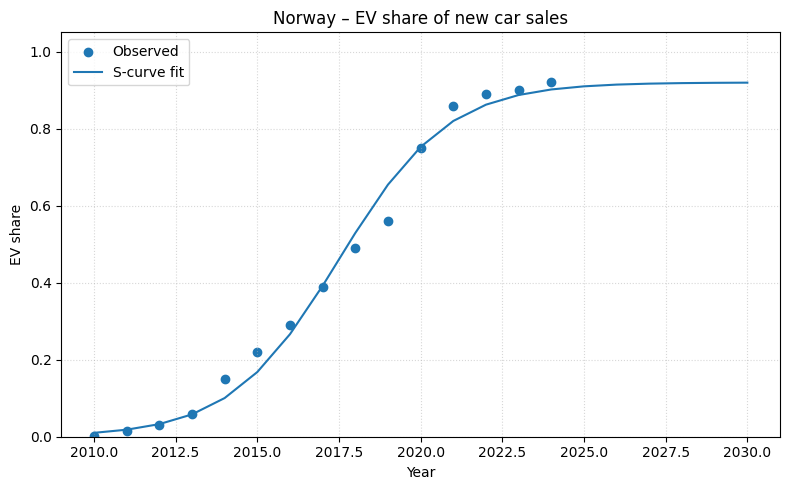

European Union (27)


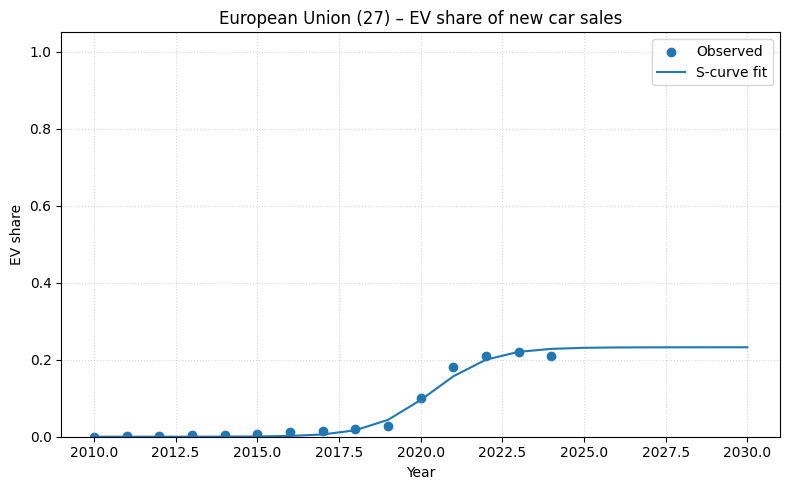

United Kingdom


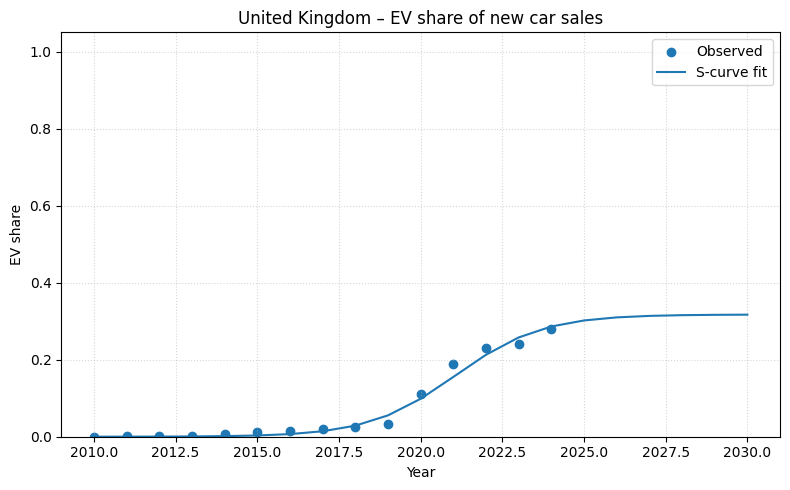

China


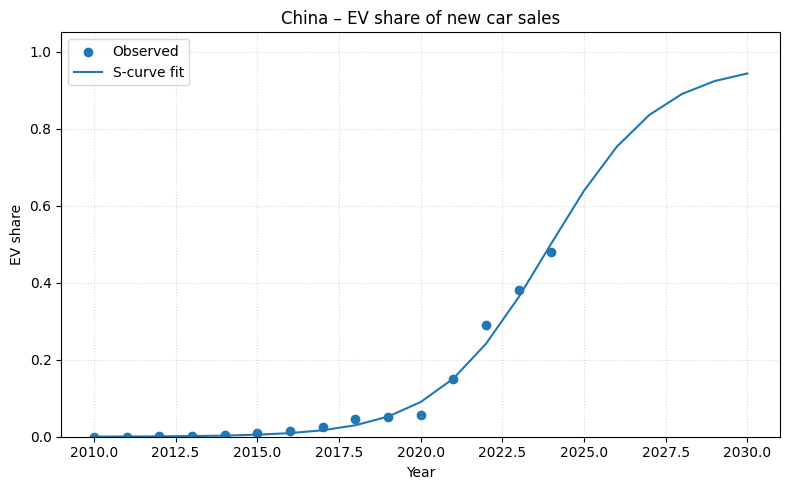

United States


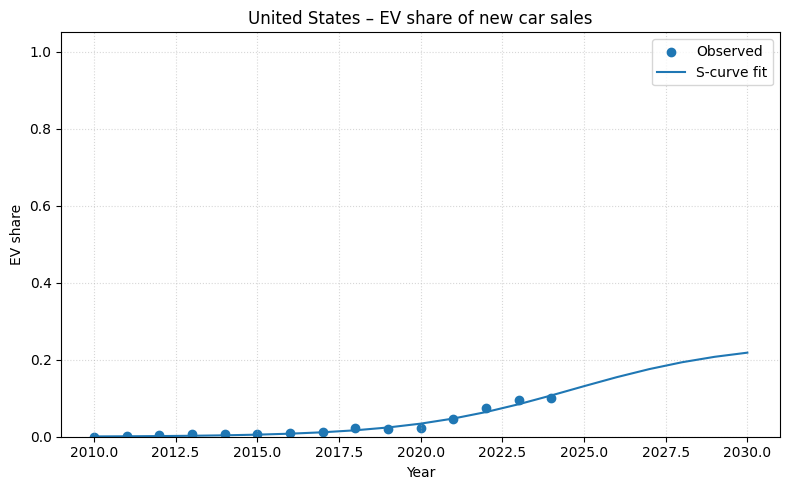

World


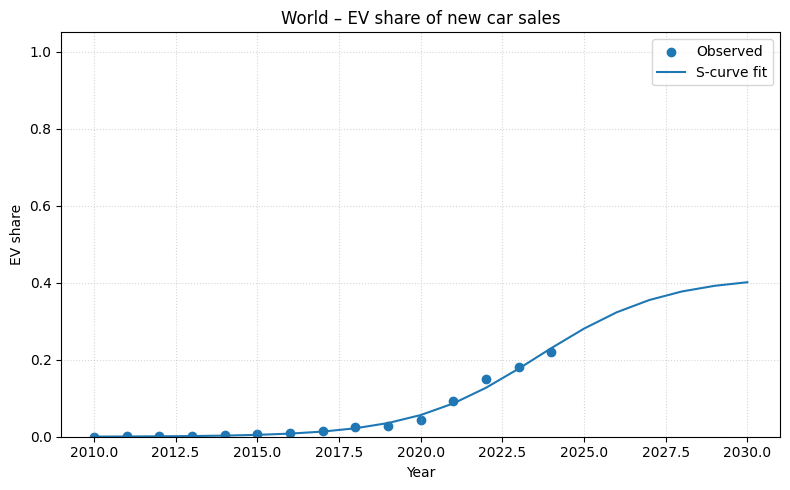

               country         L         k           t0
0               Norway  0.919833  0.600607  2017.496101
1  European Union (27)  0.232222  1.095993  2020.332025
2       United Kingdom  0.317288  0.754736  2021.058052
3                China  0.969092  0.587391  2023.878835
4        United States  0.244503  0.394254  2024.627194
5                World  0.415643  0.517377  2023.585230


<Figure size 640x480 with 0 Axes>

In [ ]:
%run owid_ev_scurve_projection.py

## The early saturations below a fraction of 1 in the year 2030 shows that the EV adoption is losing momentum recently.

## Policy Timeline

Saved figure → out/ev_policy_timeline_staggered.png


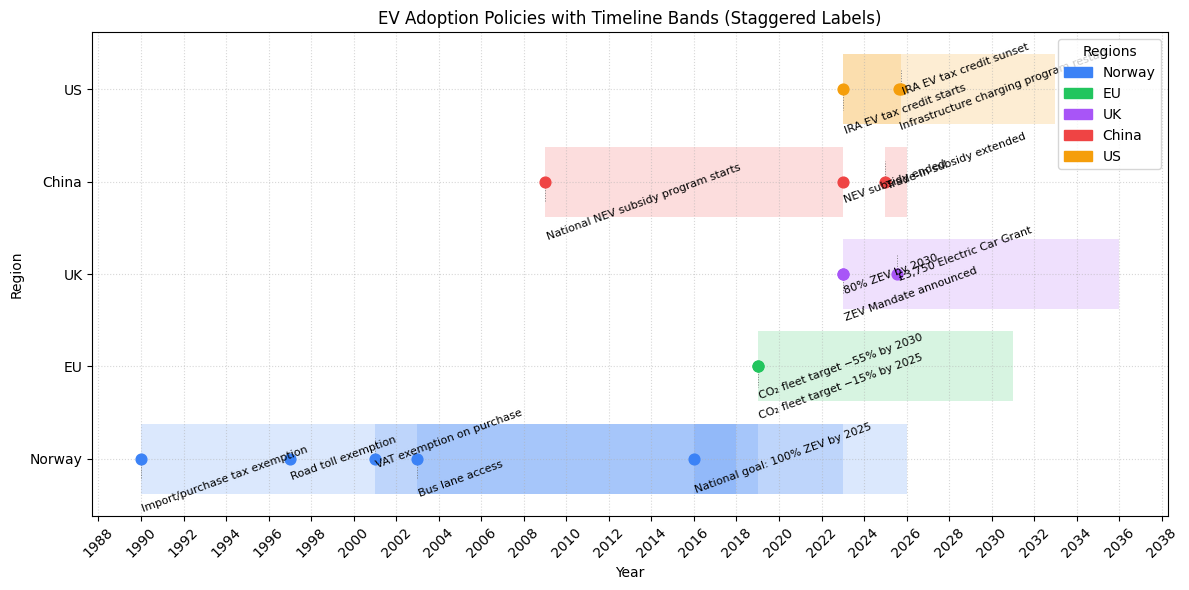

<Figure size 640x480 with 0 Axes>

In [4]:
%run ev_policy_timeline_staggered.py